In [8]:
from moll.core.distance import euclidean
from moll.core.diversity import OnlineDiversityPicker
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm

Initialize picker object

In [9]:
picker = OnlineDiversityPicker(n_points=100, dist=euclidean, n_neighbors=3)

Initialize random bathes

In [10]:
batches = jax.random.uniform(jax.random.PRNGKey(0), (1000, 1000, 2))

Run computation

In [11]:
for batch in tqdm(batches):
    picker.extend(batch)

100%|██████████| 1000/1000 [00:10<00:00, 96.10it/s]


Take selected points

In [12]:
x_sel, y_sel = picker.points.T

Too many points to plot, take only the last batch

In [13]:
x, y = batch.reshape(-1, 2).T

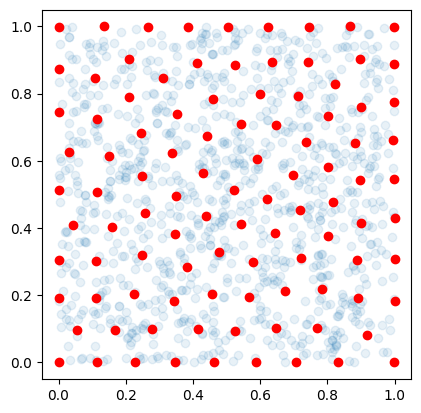

In [14]:
plt.axes().set_aspect("equal")
plt.scatter(x, y, alpha=0.1)
plt.scatter(x_sel, y_sel, c="r")
plt.show()